In [302]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [303]:
#Load data into dataframe
df = pd.read_csv('wdbc.data',header = None)


In [304]:
#Preprocess the data for creating 0-1 labelling and also for normalization
def preprocess(df):
#     print(df[1])
    cancer = {'M': 1,'B': 0} 
    df[1] = [cancer[item] for item in df[1]]
    out = df.copy()
    for f in df.columns[2:]:
        max_val = df[f].max()
        min_val = df[f].min()
        out[f] = (df[f] - min_val) / (max_val - min_val)
    return out

In [305]:
norm_df = preprocess(df)
norm_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,1,0.521037,0.022658,0.545989,0.363733,0.593753,0.792037,0.703140,0.731113,...,0.620776,0.141525,0.668310,0.450698,0.601136,0.619292,0.568610,0.912027,0.598462,0.418864
1,842517,1,0.643144,0.272574,0.615783,0.501591,0.289880,0.181768,0.203608,0.348757,...,0.606901,0.303571,0.539818,0.435214,0.347553,0.154563,0.192971,0.639175,0.233590,0.222878
2,84300903,1,0.601496,0.390260,0.595743,0.449417,0.514309,0.431017,0.462512,0.635686,...,0.556386,0.360075,0.508442,0.374508,0.483590,0.385375,0.359744,0.835052,0.403706,0.213433
3,84348301,1,0.210090,0.360839,0.233501,0.102906,0.811321,0.811361,0.565604,0.522863,...,0.248310,0.385928,0.241347,0.094008,0.915472,0.814012,0.548642,0.884880,1.000000,0.773711
4,84358402,1,0.629893,0.156578,0.630986,0.489290,0.430351,0.347893,0.463918,0.518390,...,0.519744,0.123934,0.506948,0.341575,0.437364,0.172415,0.319489,0.558419,0.157500,0.142595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,1,0.690000,0.428813,0.678668,0.566490,0.526948,0.296055,0.571462,0.690358,...,0.623266,0.383262,0.576174,0.452664,0.461137,0.178527,0.328035,0.761512,0.097575,0.105667
565,926682,1,0.622320,0.626987,0.604036,0.474019,0.407782,0.257714,0.337395,0.486630,...,0.560655,0.699094,0.520892,0.379915,0.300007,0.159997,0.256789,0.559450,0.198502,0.074315
566,926954,1,0.455251,0.621238,0.445788,0.303118,0.288165,0.254340,0.216753,0.263519,...,0.393099,0.589019,0.379949,0.230731,0.282177,0.273705,0.271805,0.487285,0.128721,0.151909
567,927241,1,0.644564,0.663510,0.665538,0.475716,0.588336,0.790197,0.823336,0.755467,...,0.633582,0.730277,0.668310,0.402035,0.619626,0.815758,0.749760,0.910653,0.497142,0.452315


In [306]:
#Split data based on Malignant and Benign labels
df_M = norm_df.loc[norm_df[1] == 1]
df_B = norm_df.loc[norm_df[1] == 0]


In [307]:
#Random sample for 70% train, 20% validation and 10% test data for both Malignant and Benign labels
train_M,valid_M,test_M = np.split(df_M.sample(frac=1), [int(.7*len(df_M)), int(.9*len(df_M))])
train_B,valid_B,test_B = np.split(df_B.sample(frac=1), [int(.7*len(df_B)), int(.9*len(df_B))])


In [308]:
#Concatenate Malignant and Benign labels into single Train, Validation and Test sets
train = pd.concat([train_M,train_B])
valid = pd.concat([valid_M,valid_B])
test = pd.concat([test_M,test_B])

In [309]:
#Create train, valid & test using 30 features
train1 = train[train.columns[2:]]
valid1 = valid[valid.columns[2:]]
test1 = test[test.columns[2:]]
K = 5

In [310]:
#Create labels from table 
train_y = np.array(train[train.columns[1]])
valid_y = np.array(valid[valid.columns[1]])
test_y = np.array(test[test.columns[1]])

In [311]:
#Finding nearest neighbour of the data points using eucledian distance calculation
def neighbour(data,neighbor):
    list1=[]
    for i in range(data.shape[0]):
        list2=[]
        for j in range(data.shape[0]):
            s=0
            for k in range(data.shape[1]):
                s+=(data.iloc[i,k]-data.iloc[j,k])**2
            s=s**0.5
            list2.append([s,j])
        list2.sort()
        list2=list2[:neighbor]
        list1.append(list2)
    return list1


In [312]:
#Aggregating 1 level of graph neighbours
def average(data,nlist):
    arr=np.zeros(data.shape)
    for i in range(len(nlist)):
        for k in range(data.shape[1]):
            s=0
            for j in range(len(nlist[i])):
                s+=data.iloc[nlist[i][j][1],k]
                s=s/len(nlist[i])
            arr[i,k]=s
    return arr

In [313]:
#aggregation of Train data neighbours
train_KNN = neighbour(train1,K)
train_x = average(train1,train_KNN)
train_x

array([[0.1014301 , 0.11468402, 0.10451073, ..., 0.18395601, 0.07251542,
        0.08366052],
       [0.08299946, 0.08684672, 0.08220692, ..., 0.15088814, 0.08380575,
        0.08155878],
       [0.10400173, 0.11062574, 0.10628067, ..., 0.19049622, 0.15448153,
        0.07153312],
       ...,
       [0.07359529, 0.07439237, 0.07192798, ..., 0.10526241, 0.05902628,
        0.0556379 ],
       [0.06613832, 0.03372337, 0.06388786, ..., 0.05814187, 0.04360434,
        0.02881205],
       [0.06421701, 0.06120376, 0.06021141, ..., 0.02356553, 0.02012146,
        0.01317365]])

In [314]:
#aggregation of Validation data neighbours
valid_KNN = neighbour(valid1,K)
valid_x = average(valid1,valid_KNN)
valid_x

array([[0.1444504 , 0.11449507, 0.14435516, ..., 0.14911131, 0.08094764,
        0.06191969],
       [0.06802524, 0.11036018, 0.06509558, ..., 0.05669097, 0.0703296 ,
        0.04091181],
       [0.14831814, 0.14680771, 0.15312127, ..., 0.16802012, 0.06614809,
        0.07144396],
       ...,
       [0.05665039, 0.06529775, 0.05541993, ..., 0.05698111, 0.07006726,
        0.03334106],
       [0.0574661 , 0.06468101, 0.05633181, ..., 0.05623704, 0.06933876,
        0.03658908],
       [0.08319726, 0.05314186, 0.07905064, ..., 0.070048  , 0.03217593,
        0.01945458]])

In [315]:
#aggregation of test data neighbours
test_KNN = neighbour(test1,K)
test_x = average(test1,test_KNN)
test_x

array([[0.13223727, 0.06309487, 0.12887416, ..., 0.1386692 , 0.0685603 ,
        0.04481261],
       [0.16867386, 0.11336333, 0.16696059, ..., 0.18378337, 0.08136686,
        0.0422193 ],
       [0.1640007 , 0.10461284, 0.16146414, ..., 0.1658008 , 0.06615945,
        0.01557042],
       ...,
       [0.08885288, 0.06168771, 0.08747132, ..., 0.1007601 , 0.08865091,
        0.06035837],
       [0.06596551, 0.06053595, 0.06441975, ..., 0.08821308, 0.07829623,
        0.03814118],
       [0.06784168, 0.04383665, 0.06632673, ..., 0.05497642, 0.04787864,
        0.06533161]])

In [316]:
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)

def relu(x):
    return np.maximum(0,x)

def relDv(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

#Neural network 
class NeuralNetwork:
    def __init__(self, x, y, v, w, a, b, lr):
        self.input      = x
        self.weights1   = np.random.rand(self.input.shape[1],self.input.shape[1])*0.1
        self.weights2   = np.random.rand(self.input.shape[1],1)*0.1   
        self.y          = y.reshape(self.input.shape[0],1)
        self.output     = np.zeros(self.y.shape)
        self.valid      = v
        self.valid_target=w
        self.test       = a
        self.test_target= b
        self.lr = lr
        #print(self.output)

    def feedforward(self):
        self.layer1 = relu(np.dot(self.input, self.weights1))
#         print(self.layer1.shape)
        self.output = sigmoid(np.dot(self.layer1, self.weights2))
#         print(self.output.shape)

    def backprop(self):
        d_weights2 = np.dot(self.layer1.T, (2*(self.y - self.output)*sigmoid_derivative(self.output)))
#         print(d_weights2.shape)
        d_weights1 = np.dot(self.input.T, np.dot(2*(self.y - self.output)*sigmoid_derivative(self.output), self.weights2.T)*relDv(self.layer1))
#         print(d_weights1.shape)
        self.weights1 += d_weights1*self.lr
        self.weights2 += d_weights2*self.lr
    
    def train(self):
        self.feedforward()
        self.backprop()
 
    def train_accuracy(self):
        self.layer = relu(np.dot(self.input, self.weights1))
        self.pred=sigmoid(np.dot(self.layer, self.weights2))
        for i in range(self.pred.shape[0]):
            if self.pred[i]<0.5:
                self.pred[i]=0
            else:
                self.pred[i]=1
        return accuracy_score(self.pred,self.y)

    def valid_accuracy(self):
        self.layer = relu(np.dot(self.valid, self.weights1))
        self.pred=sigmoid(np.dot(self.layer, self.weights2))
        for i in range(self.pred.shape[0]):
            if self.pred[i]<0.5:
                self.pred[i]=0
            else:
                self.pred[i]=1
        return accuracy_score(self.pred,self.valid_target)

    def test_accuracy(self):
        self.layer = relu(np.dot(self.test, self.weights1))
        self.pred=sigmoid(np.dot(self.layer, self.weights2))
        for i in range(self.pred.shape[0]):
            if self.pred[i]<0.5:
                self.pred[i]=0
            else:
                self.pred[i]=1
        return accuracy_score(self.pred,self.test_target)


In [317]:
#Creating Neural network with data and learning rate
lr = 0.02
NN = NeuralNetwork(train_x,train_y,valid_x,valid_y,test_x,test_y,lr)
x1 = [] 
y1_train = []
y1_valid = []
y1_test = []
for i in range(1000):

    
    if i%50 == 0:
        x1.append(i)
        y1_train.append(round(NN.train_accuracy(),3))
        y1_valid.append(round(NN.valid_accuracy(),3))
        y1_test.append(round(NN.test_accuracy(),3))
        print("Iteration: {}".format(i))
        print("Train: {} ".format(NN.train_accuracy()))
        print("Valid: {} ".format(NN.valid_accuracy()))
        print("Test: {} ".format(NN.test_accuracy()))
        print("\n")
    NN.train()
    

Iteration: 0
Train: 0.37279596977329976 
Valid: 0.3684210526315789 
Test: 0.3793103448275862 


Iteration: 50
Train: 0.889168765743073 
Valid: 0.8947368421052632 
Test: 0.896551724137931 


Iteration: 100
Train: 0.9093198992443325 
Valid: 0.8859649122807017 
Test: 0.9310344827586207 


Iteration: 150
Train: 0.929471032745592 
Valid: 0.9035087719298246 
Test: 0.9482758620689655 


Iteration: 200
Train: 0.9420654911838791 
Valid: 0.9035087719298246 
Test: 0.9482758620689655 


Iteration: 250
Train: 0.9445843828715366 
Valid: 0.8947368421052632 
Test: 0.9655172413793104 


Iteration: 300
Train: 0.947103274559194 
Valid: 0.8947368421052632 
Test: 0.9655172413793104 


Iteration: 350
Train: 0.947103274559194 
Valid: 0.8947368421052632 
Test: 0.9655172413793104 


Iteration: 400
Train: 0.9521410579345088 
Valid: 0.8947368421052632 
Test: 0.9655172413793104 


Iteration: 450
Train: 0.9546599496221663 
Valid: 0.8947368421052632 
Test: 0.9655172413793104 


Iteration: 500
Train: 0.9571788413098

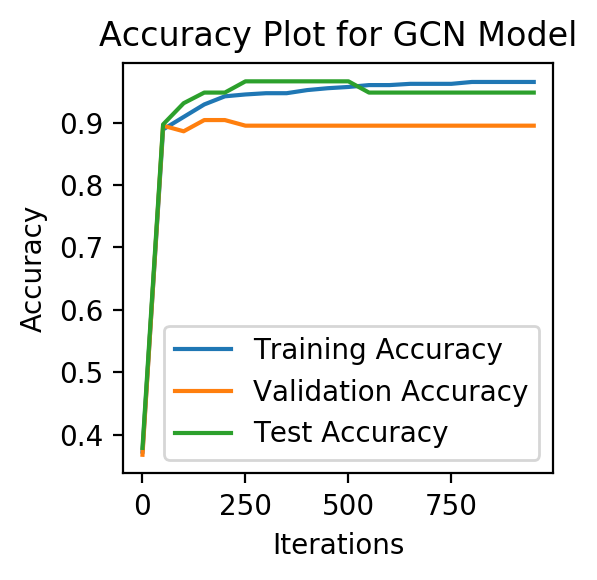

In [318]:
import matplotlib.pyplot as plt 

width_in_inches = 3
height_in_inches = 3
dots_per_inch = 200

plt.figure(
    figsize=(width_in_inches, height_in_inches),
    dpi=dots_per_inch)

# plotting the line 1 points  
plt.plot(x1, y1_train, label = "Training Accuracy") 
   
# plotting the line 2 points  
plt.plot(x1, y1_valid, label = "Validation Accuracy") 

plt.plot(x1, y1_test, label = "Test Accuracy") 
  
# naming the x axis 
plt.xlabel('Iterations') 
# naming the y axis 
plt.ylabel('Accuracy') 
# giving a title to my graph 
plt.title('Accuracy Plot for GCN Model') 

plt.tight_layout()
# show a legend on the plot 
plt.legend() 

# function to show the plot 
plt.show() 


In [319]:
#Classification using sklearn-KNN 
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5)
model.fit(train_x,train_y)

predicted1= model.predict(test_x) 
predicted1_v= model.predict(valid_x) 
print("KNN accuracy on valid:{}".format((1-(abs(predicted1_v-valid_y).sum()/valid_y.sum()))*100))
print("KNN accuracy on test:{}".format((1-(abs(predicted1-test_y).sum()/test_y.sum()))*100))

KNN accuracy on valid:83.33333333333334
KNN accuracy on test:86.36363636363636


In [320]:
#Classification using sklearn-SVM 
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='rbf') # Linear Kernel

#Train the model using the training sets
clf.fit(train_x, train_y)

#Predict the response for test dataset
predicted2 = clf.predict(test_x)
predicted2_v = clf.predict(valid_x)
print("SVM accuracy on valid:{}".format((1-(abs(predicted2_v-valid_y).sum()/valid_y.sum()))*100))
print("SVM accuracy on test:{}".format((1-(abs(predicted2-test_y).sum()/test_y.sum()))*100))

SVM accuracy on valid:80.95238095238095
SVM accuracy on test:86.36363636363636


In [321]:
#Classification using sklearn-Logistic Regression 
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(train_x,train_y)

#
predicted3=logreg.predict(test_x)
predicted3_v=logreg.predict(valid_x)
print("Logistic accuracy on valid:{}".format((1-(abs(predicted3_v-valid_y).sum()/valid_y.sum()))*100))
print("Logistic accuracy on test:{}".format((1-(abs(predicted3-test_y).sum()/test_y.sum()))*100))

Logistic accuracy on valid:78.57142857142857
Logistic accuracy on test:86.36363636363636
